# Predicting Power Outages: A Comparative Study with Artificial Neural Networks

## Seungmin Lee (slee93)

## Introduction
In 2003, a significant electrical fault caused by a high-voltage power line sagging into tree branches resulted in a widespread blackout across the northeastern United States [[NASA, 2008]](https://sma.nasa.gov/docs/default-source/safety-messages/safetymessage-2008-03-01-northeastblackoutof2003.pdf). This event left over 50 million people without electricity for up to four days, underscoring the critical vulnerabilities in the power grid. The incident revealed an urgent need for enhanced situational awareness and real-time visibility into power outages, catalyzing efforts to develop more robust monitoring and response systems to mitigate such disruptions.

In response to these challenges, the U.S. Department of Energy (DOE) introduced the Environment for Analysis of Geo-Located Energy Information (EAGLE-I<sup>TM</sup>) platform. EAGLE-I<sup>TM</sup> leverages publicly available data to monitor power outages affecting electricity consumers and provides critical support to federal, state, and local planners and utility providers in addressing significant disasters such as hurricanes, winter storms, and wildfires. Beyond its real-time applications, EAGLE-I has established a comprehensive long-term database, offering county-level outage data recorded at 15-minute intervals from 2014 to 2023 [[DOE, 2024]](https://figshare.com/s/417a4f147cf1357a5391).

Aging power infrastructure and the increasing prevalence of extreme weather events are now widely recognized as primary drivers of power outages. These factors have intensified the frequency of outages and increased the challenges associated with their predictability. Within this context, EAGLE-I<sup>TM</sup> data serves as a vital resource, enabling the identification of temporal and spatial patterns of power outages and the development of predictive models. Such analyses can enhance grid stability, improve resilience, and inform proactive and effective response strategies.

This study seeks to harness the capabilities of EAGLE-I data to construct a time-based power outage prediction model. By doing so, it aims to advance the effectiveness of outage management strategies, contribute to grid reliability, and minimize the socio-economic impacts of power disruptions.


## Problem Statement

Previous research on power outage prediction has predominantly utilized regression and tree-based models to forecast disruptions [[Hou, 2020]](https://doi.org/10.1049/iet-gtd.2020.0834); [[Garland, 2021]](https://doi.org/10.1016/j.ijepes.2021.107123). While these approaches have demonstrated effectiveness in specific scenarios, the application of deep learning models still needs to be explored in this domain. Given the complexity of power outages, which are influenced by diverse climatic and seasonal factors beyond extreme events like hurricanes, there is a growing need to validate the predictive capabilities of deep learning models.
  

### _Dataset_  
**Power Outage Dataset**: This dataset is sourced from the Environment for Analysis of Geo-Located Energy Information (EAGLE-I<sup>TM</sup>) platform, which provides county-level power outage information recorded at 15-minute intervals from 2014 to 2023. For this study, data specific to Wake County, North Carolina, from 2021 to 2023 will be extracted and utilized. [[Dataset]](https://figshare.com/s/417a4f147cf1357a5391)

The dataset includes the following fields:  
* County
* State
* Number of outages
* Time point

In [1]:
import warnings
import numpy as np
import pandas as pd
from IPython.display import Image

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
warnings.filterwarnings("ignore")

In [3]:
df_21 = pd.read_csv('/content/eaglei_outages_2021.csv')
df_22 = pd.read_csv('/content/eaglei_outages_2022.csv')
df_23 = pd.read_csv('/content/eaglei_outages_2023.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/content/eaglei_outages_2021.csv'

In [ ]:
# Extract information specific to the North Carolina region (Wake county).
p_21 = df_21[df_21['fips_code'] == 37183]
p_22 = df_22[df_22['fips_code'] == 37183]
p_23 = df_23[df_23['fips_code'] == 37183]

In [ ]:
p_21.head()

,fips_code,county,state,customers_out,run_start_time
313,37183,Wake,North Carolina,1.0,2021-01-01 00:00:00
868,37183,Wake,North Carolina,1.0,2021-01-01 00:15:00
1361,37183,Wake,North Carolina,1.0,2021-01-01 00:30:00
1846,37183,Wake,North Carolina,1.0,2021-01-01 00:45:00
2336,37183,Wake,North Carolina,1.0,2021-01-01 01:00:00


**Weather Dataset**: The weather dataset is sourced from the Local Climatological Data provided by the National Centers for Environmental Information (NCEI). Specifically, data from the Raleigh-Durham International Airport (NC, US) station was utilized. [[Dataset]](https://www.ncei.noaa.gov/)  
* Hourly Climate Data
* Daily Climate Data
* Monthly Climate Data  

For this study, hourly climate data will be utilized.

In [ ]:
wd_21 = pd.read_csv('/content/weather_2021.csv')
wd_22 = pd.read_csv('/content/weather_2022.csv')
wd_23 = pd.read_csv('/content/weather_2023.csv')

In [ ]:
wd_21.head()

,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,REPORT_TYPE,SOURCE,HourlyAltimeterSetting,HourlyDewPointTemperature,...,BackupDirection,BackupDistance,BackupDistanceUnit,BackupElements,BackupElevation,BackupEquipment,BackupLatitude,BackupLongitude,BackupName,WindEquipmentChangeDate
0,72306013722,2021-01-01T00:10:00,35.89227,-78.78194,120.5,"RALEIGH DURHAM INTERNATIONAL AIRPORT, NC US",FM-16,7,30.25,54.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-07-08
1,72306013722,2021-01-01T00:23:00,35.89227,-78.78194,120.5,"RALEIGH DURHAM INTERNATIONAL AIRPORT, NC US",FM-16,7,30.25,54.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-07-08
2,72306013722,2021-01-01T00:51:00,35.89227,-78.78194,120.5,"RALEIGH DURHAM INTERNATIONAL AIRPORT, NC US",FM-15,7,30.27,52.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-07-08
3,72306013722,2021-01-01T01:00:00,35.89227,-78.78194,120.5,"RALEIGH DURHAM INTERNATIONAL AIRPORT, NC US",FM-12,4,NaN,52.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-07-08
4,72306013722,2021-01-01T01:51:00,35.89227,-78.78194,120.5,"RALEIGH DURHAM INTERNATIONAL AIRPORT, NC US",FM-15,7,30.31,47.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-07-08


### _Objective_

* The objective of this study is to develop a time-series-based prediction model to forecast power outages at an hourly resolution for Wake County, North Carolina.   

### _Performance metric_  

* Previous studies have used evaluation metrics such as MAE, MSE, RMSE, and R² [[Fatima, 2024]](https://doi.org/10.1016/j.engappai.2024.108056). This study aim to use MAE, MSE, and RMSE to evaluate the model's accuracy from multiple perspectives.
* Mean Absolute Error (MAE):MAE calculates the average of the absolute differences between the predicted and actual values.  

$$MAE=\frac{1}{n}\sum_{i=1}^{n}\left| y_{i}-\hat{y_{i}}\right|$$
* Mean Squared Error (MSE): MSE measures the average of the squared differences between the predicted and actual values.
$$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$
* Root Mean Squared Error (RMSE):
RMSE is the square root of MSE, combining the advantages of error squaring with a return to the original units of the target variable.
$$RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$



### _State of the art_

* [[Hou, 2020]](https://doi.org/10.1049/iet-gtd.2020.0834) proposed a data-driven method for power outage prediction. The study compared the performance of various models, including Ridge Regression, Support Vector Regression (SVR), Classification and Regression Tree (CART), Gradient Boosting Decision Tree (GBDT), and Random Forest (RF). As shown in the following figure(upper image), the RF model demonstrated the best performance among the tested methods.

* [[Garland, 2021]](https://doi.org/10.1016/j.ijepes.2021.107123) conducted a study focused on predicting power outage duration (regression) and occurrence (classification) in the California region using historical weather data. The performance of various models, including LASSO and Ridge Regression, Regression Trees, Stochastic Gradient Boosting (SG Boost), Adaboost, and Multi-layer Feed Forward Neural Networks (MFFNN), was compared. As shown in the following image(lower image), the MFFNN model consistently outperformed the other methods, whether using date-time splits or randomly shuffled data.

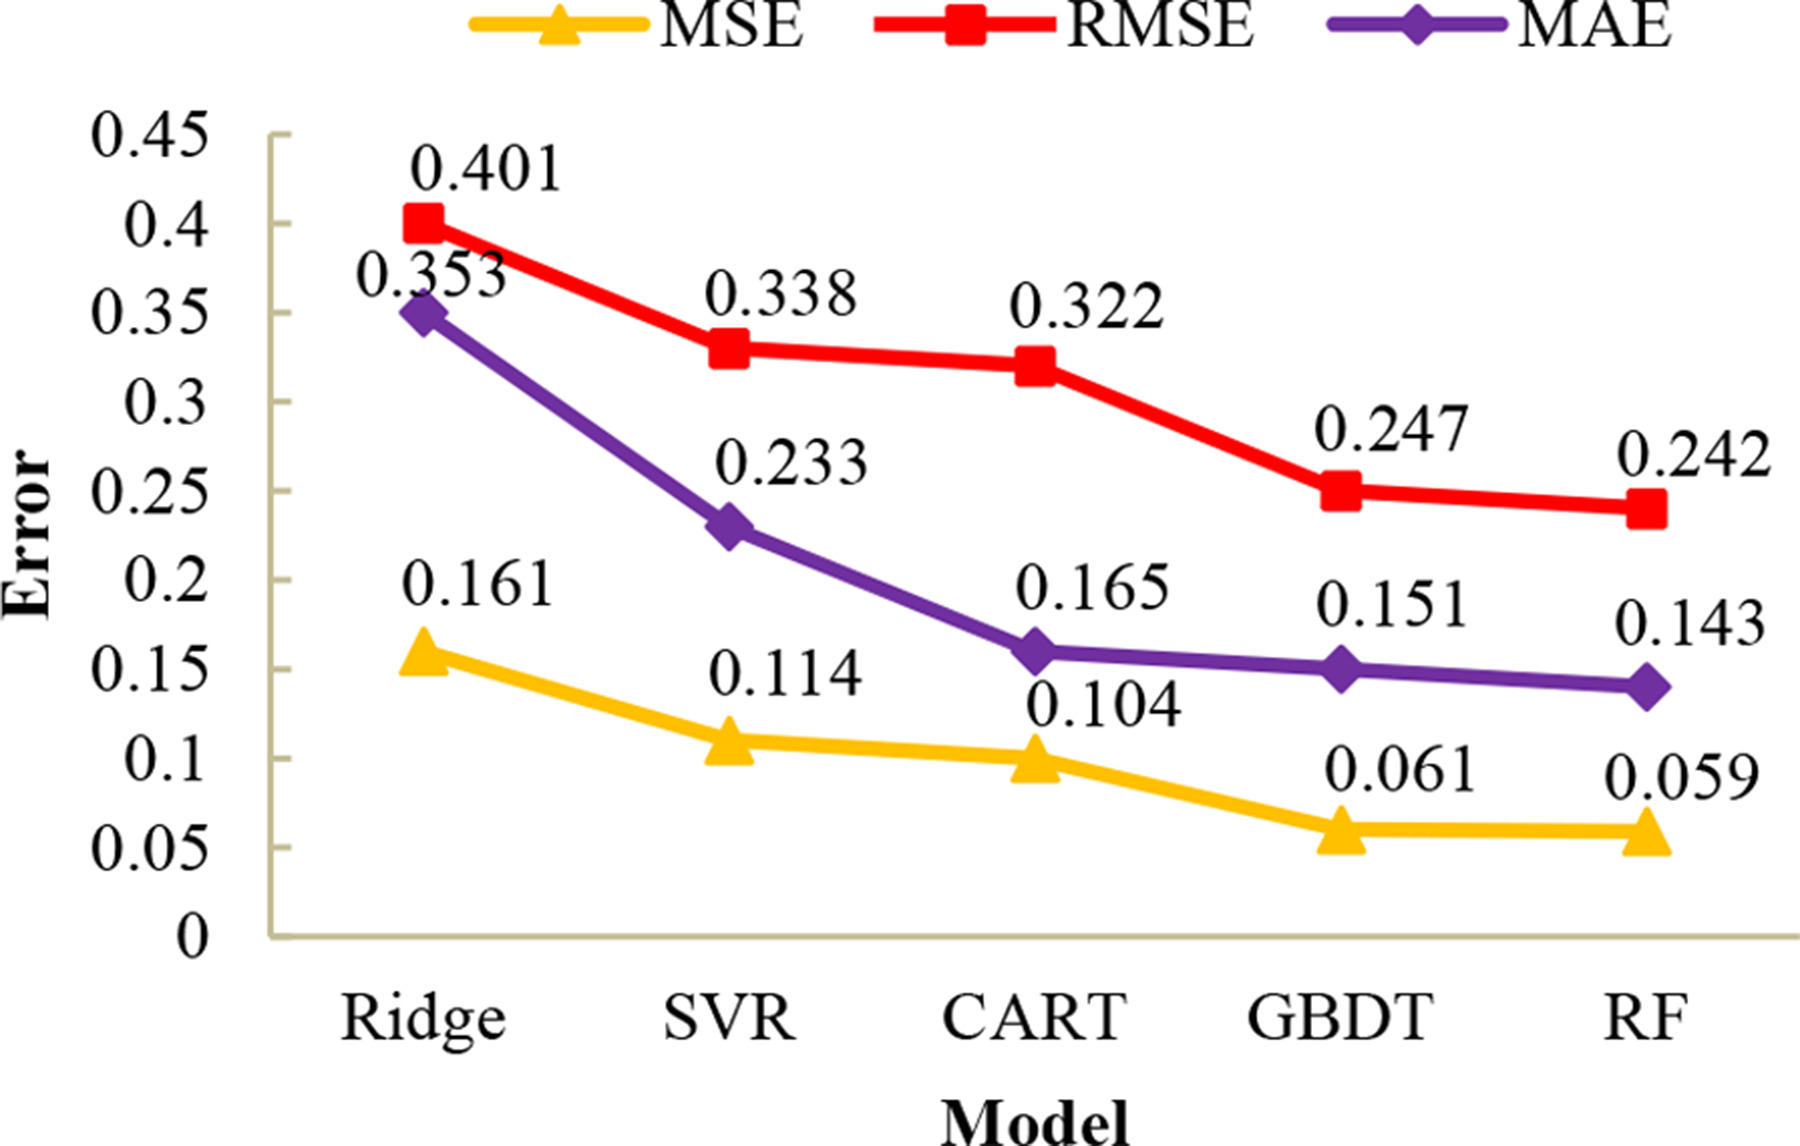

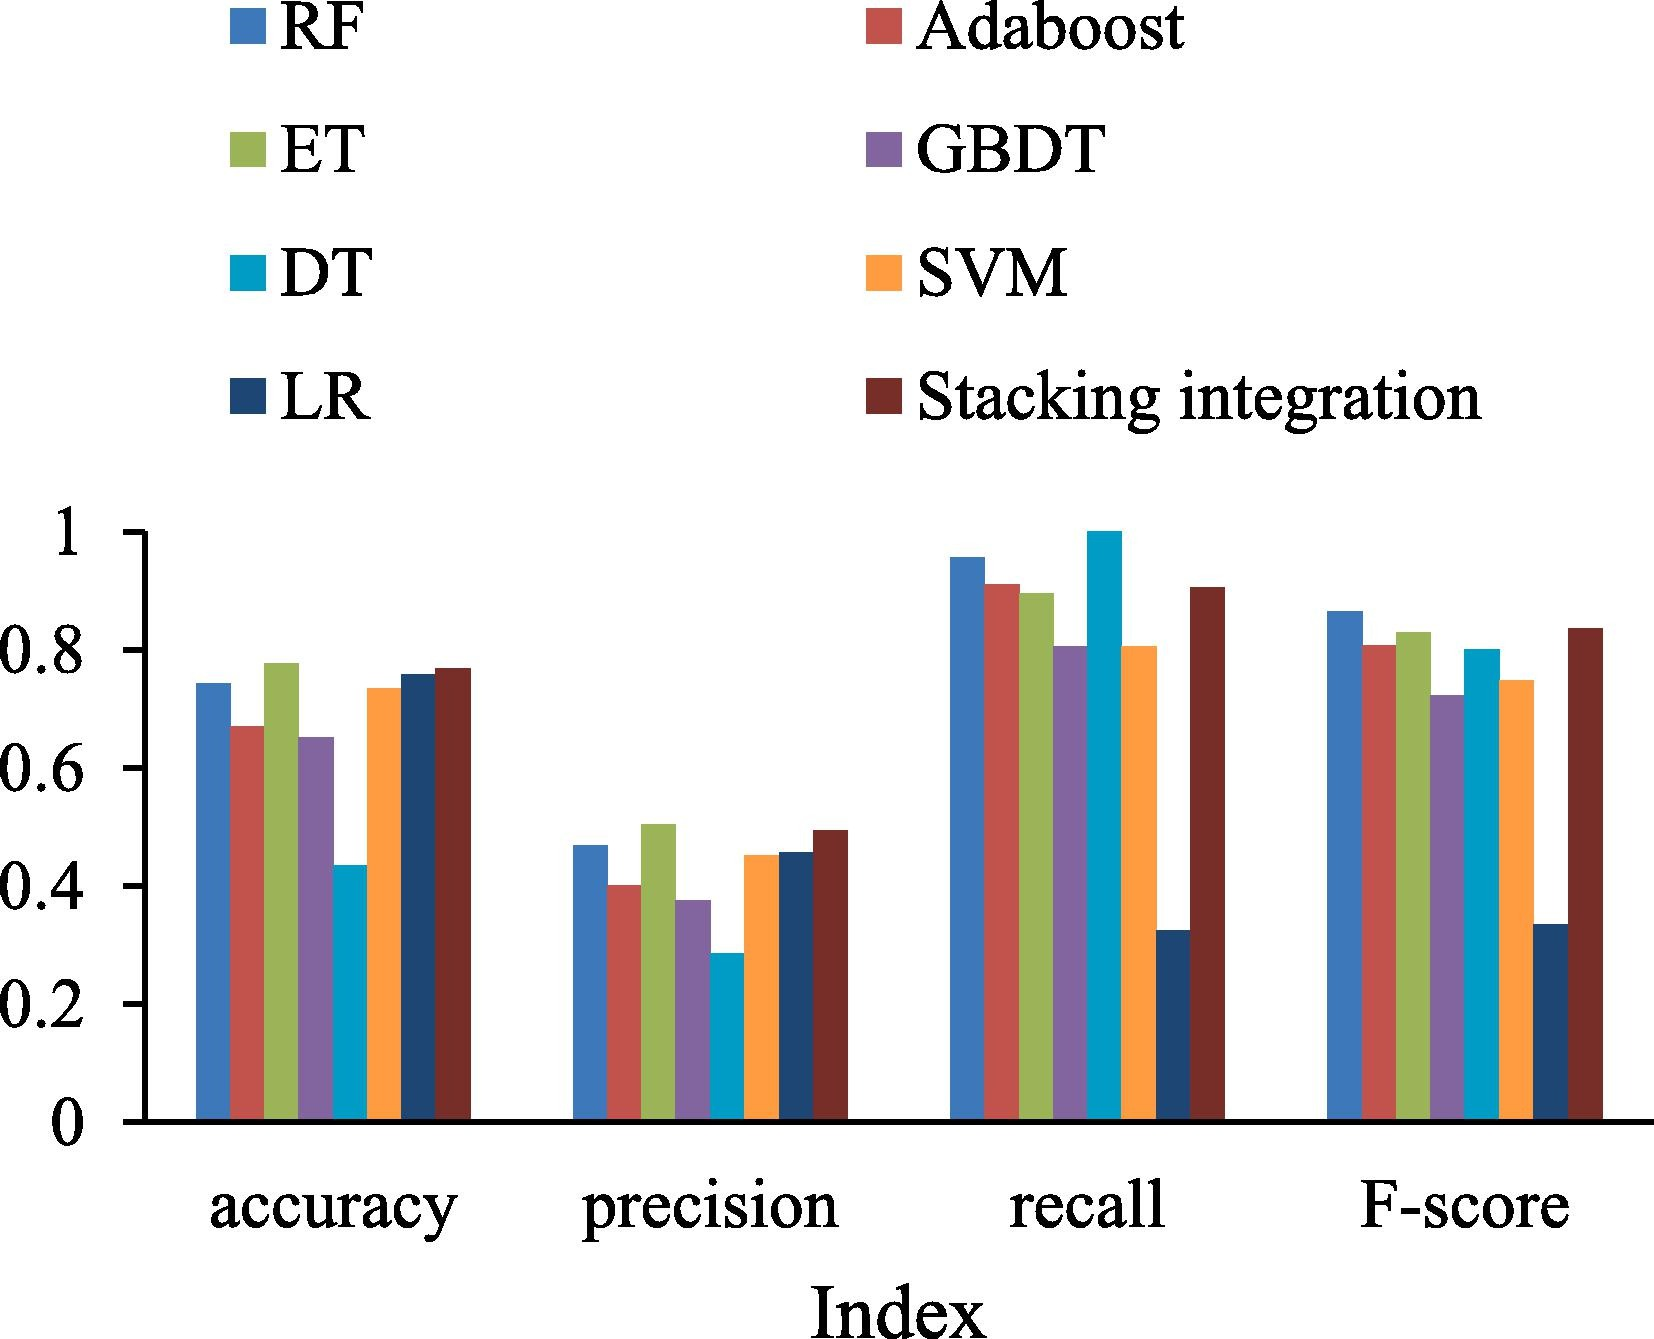

In [ ]:
display(
    Image('/content/image_3.jpg', width=600),
    Image('/content/image_2.jpg', width=600)
)

### _Data preprocessing_  

* Power Outage Dataset

In [ ]:
# Extraction of data on time and the number of power outage occurrences
p_21 = p_21.iloc[:, -2:]
p_22 = p_22.iloc[:, -2:]
p_23 = p_23.iloc[:, -2:]

p_21.columns = ['num', 'Time point']
p_22.columns = ['num', 'Time point']
p_23.columns = ['num', 'Time point']

In [ ]:
# Combine the three DataFrames vertically
total_p = pd.concat([p_21, p_22, p_23], axis=0, ignore_index=True)
total_p = total_p[['Time point', 'num']]

In [ ]:
total_p['Time point'] = pd.to_datetime(total_p['Time point'])

In [ ]:
nan_rows = total_p[total_p['num'].isnull()]

print(nan_rows)

               Time point  num
476   2021-01-07 16:45:00  NaN
1177  2021-01-18 01:30:00  NaN
1188  2021-01-18 07:00:00  NaN
1238  2021-01-19 07:45:00  NaN
1436  2021-01-23 14:15:00  NaN
...                   ...  ...
24255 2021-12-01 08:15:00  NaN
24256 2021-12-01 08:30:00  NaN
24257 2021-12-01 08:45:00  NaN
25229 2021-12-15 06:15:00  NaN
25278 2021-12-16 07:45:00  NaN

[98 rows x 2 columns]


In [ ]:
# Linear interpolation
total_p['num'] = total_p['num'].interpolate(method='linear')

In [ ]:
# Floor 'Time point' to the nearest hour
total_p['Time point'] = total_p['Time point'].dt.floor('H')

# Group by hour and keep only the row with the maximum 'num'
final_p = total_p.loc[total_p.groupby('Time point')['num'].idxmax()]
final_p = final_p.reset_index(drop=True)

In [ ]:
full_range = pd.date_range(start='2021-01-01 00:00:00', end='2023-12-31 23:00:00', freq='H')
p_full = pd.DataFrame({'Time point': full_range})

p_full = pd.merge(p_full, final_p, on='Time point', how='left')

# Apply linear interpolation to fill missing values in the 'num' column
p_full['num'] = p_full['num'].interpolate(method='linear')

In [ ]:
# Round the values in the 'num' column to the nearest integer
p_full['num'] = p_full['num'].round().astype(int)

In [ ]:
p_full.describe()

,Time point,num
count,26280,26280.000000
mean,2022-07-02 11:30:00,310.895472
min,2021-01-01 00:00:00,0.000000
25%,2021-10-01 17:45:00,3.000000
50%,2022-07-02 11:30:00,16.000000
75%,2023-04-02 05:15:00,82.000000
max,2023-12-31 23:00:00,95005.000000
std,NaN,2905.882679


The maximum value of "num" was determined not to be an outlier, as Wake County has experienced several hurricanes (e.g., Hurricane Ian in 2022), which could have caused large-scale power outages.

* Weather Dataset

In [ ]:
w_21 = wd_21[wd_21['REPORT_TYPE'] == 'FM-15']
w_22 = wd_22[wd_22['REPORT_TYPE'] == 'FM-15']
w_23 = wd_23[wd_23['REPORT_TYPE'] == 'FM-15']

In [ ]:
# List of columns to extract
columns_to_extract = [
    'DATE',
    'HourlyDewPointTemperature',
    'HourlyDryBulbTemperature',
    'HourlyPressureChange',
    'HourlyPressureTendency',
    'HourlyRelativeHumidity',
    'HourlySeaLevelPressure',
    'HourlyStationPressure',
    'HourlyVisibility',
    'HourlyWetBulbTemperature',
    'HourlyWindDirection',
    'HourlyWindSpeed'
]

# Extract the specified columns
w_21_new = w_21[columns_to_extract]
w_22_new = w_22[columns_to_extract]
w_23_new = w_23[columns_to_extract]

In [ ]:
w_21_new['DATE'] = pd.to_datetime(w_21_new['DATE'])
w_22_new['DATE'] = pd.to_datetime(w_22_new['DATE'])
w_23_new['DATE'] = pd.to_datetime(w_23_new['DATE'])

In [ ]:
w_21_new['Hour'] = w_21_new['DATE'].dt.floor('H')
w_21_new['Time_Diff'] = (w_21_new['DATE'] - w_21_new['Hour']).dt.total_seconds().abs()
w_21_new2 = w_21_new.loc[w_21_new.groupby('Hour')['Time_Diff'].idxmin()]
w_21_new2 = w_21_new2.drop(columns=['Hour', 'Time_Diff'])

w_22_new['Hour'] = w_22_new['DATE'].dt.floor('H')
w_22_new['Time_Diff'] = (w_22_new['DATE'] - w_22_new['Hour']).dt.total_seconds().abs()
w_22_new2 = w_22_new.loc[w_22_new.groupby('Hour')['Time_Diff'].idxmin()]
w_22_new2 = w_22_new2.drop(columns=['Hour', 'Time_Diff'])

w_23_new['Hour'] = w_23_new['DATE'].dt.floor('H')
w_23_new['Time_Diff'] = (w_23_new['DATE'] - w_23_new['Hour']).dt.total_seconds().abs()
w_23_new2 = w_23_new.loc[w_23_new.groupby('Hour')['Time_Diff'].idxmin()]
w_23_new2 = w_23_new2.drop(columns=['Hour', 'Time_Diff'])

In [ ]:
total_w = pd.concat([w_21_new2, w_22_new2, w_23_new2], axis=0, ignore_index=True)

In [ ]:
total_w['DATE'] = total_w['DATE'].dt.floor('H')

In [ ]:
full_range = pd.date_range(start='2021-01-01 00:00:00', end='2023-12-31 23:00:00', freq='H')

# Create a DataFrame containing the full range of timestamps
full_df = pd.DataFrame({'DATE': full_range})

# Merge the original data with the full range
final_w = pd.merge(full_df, total_w, on='DATE', how='left')

# Perform linear interpolation to fill missing values
final_w = final_w.interpolate(method='linear', limit_direction='forward', axis=0)

In [ ]:
final_w['HourlyPressureChange'] = final_w['HourlyPressureChange'].interpolate(method='linear')

final_w['HourlyPressureTendency'] = final_w['HourlyPressureTendency'].interpolate(method='linear')
final_w['HourlyPressureTendency'] = final_w['HourlyPressureTendency'].round(0).astype(int)

In [ ]:
# Replace 'VRB' and other non-numeric values with NaN
final_w['HourlyWindDirection'] = pd.to_numeric(final_w['HourlyWindDirection'], errors='coerce')

# Perform linear interpolation
final_w['HourlyWindDirection'] = final_w['HourlyWindDirection'].interpolate(method='linear', limit_direction='both')

# Convert interpolated values to integers
final_w['HourlyWindDirection'] = final_w['HourlyWindDirection'].round().astype('Int64')

In [ ]:
for col in final_w.columns:
    if col != 'DATE':
        final_w[col] = pd.to_numeric(final_w[col], errors='coerce')

In [ ]:
final_w.interpolate(method='linear', limit_direction='both', inplace=True)

for col in final_w.columns:
    if col != 'DATE' and col != 'HourlySeaLevelPressure':
        final_w[col] = final_w[col].round().astype(int)

In [ ]:
# Combining Power Outage Data with Weather Data
df_full = pd.merge(p_full, final_w, left_on='Time point', right_on='DATE', how='inner')
df_full = df_full.drop(columns=['DATE'])

In [ ]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26280 entries, 0 to 26279
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Time point                 26280 non-null  datetime64[ns]
 1   num                        26280 non-null  int64         
 2   HourlyDewPointTemperature  26280 non-null  int64         
 3   HourlyDryBulbTemperature   26280 non-null  int64         
 4   HourlyPressureChange       26280 non-null  int64         
 5   HourlyPressureTendency     26280 non-null  int64         
 6   HourlyRelativeHumidity     26280 non-null  int64         
 7   HourlySeaLevelPressure     26280 non-null  float64       
 8   HourlyStationPressure      26280 non-null  int64         
 9   HourlyVisibility           26280 non-null  int64         
 10  HourlyWetBulbTemperature   26280 non-null  int64         
 11  HourlyWindDirection        26280 non-null  int64         
 12  Hour

In [ ]:
df_full.describe()

,Time point,num,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPressureChange,HourlyPressureTendency,HourlyRelativeHumidity,HourlySeaLevelPressure,HourlyStationPressure,HourlyVisibility,HourlyWetBulbTemperature,HourlyWindDirection,HourlyWindSpeed
count,26280,26280.000000,26280.000000,26280.000000,26280.0,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000
mean,2022-07-02 11:30:00,310.895472,50.413470,62.396651,0.0,4.225875,68.366971,30.058950,29.700304,9.400685,56.049163,129.032154,5.735312
min,2021-01-01 00:00:00,0.000000,-7.000000,10.000000,0.0,0.000000,11.000000,29.220000,29.000000,0.000000,7.000000,0.000000,0.000000
25%,2021-10-01 17:45:00,3.000000,36.000000,50.000000,0.0,2.000000,52.000000,29.930000,29.000000,10.000000,44.000000,10.000000,3.000000
50%,2022-07-02 11:30:00,16.000000,54.000000,64.000000,0.0,4.000000,70.000000,30.060000,30.000000,10.000000,58.000000,125.000000,6.000000
75%,2023-04-02 05:15:00,82.000000,65.000000,75.000000,0.0,6.000000,87.000000,30.180000,30.000000,10.000000,69.000000,230.000000,8.000000
max,2023-12-31 23:00:00,95005.000000,80.000000,102.000000,0.0,8.000000,100.000000,30.770000,30.000000,10.000000,82.000000,360.000000,37.000000
std,NaN,2905.882679,17.273597,16.310950,0.0,2.392394,20.690179,0.194047,0.458133,1.905136,14.742924,110.041898,4.498719


## Methodology

This study employs a simple Artificial Neural Network (ANN) model to predict power outages. The proposed ANN architecture consists of two hidden layers with Tanh activation functions, enabling the model to capture non-linear relationships between features and power outage occurrences. Unlike traditional regression and tree-based models, which often require extensive manual feature engineering, the ANN automatically learns feature representations, making it suitable for high-dimensional and complex datasets [[Z. Q. John Lu, 2010]](https://doi.org/10.1111/j.1467-985X.2010.00646_6.x). This architecture is particularly effective in modeling the diverse climatic and infrastructure-related factors influencing outages. By leveraging the scalability and flexibility of neural networks, this approach addresses the limitations of classical models, providing accurate and robust predictions under varying conditions.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
df_full['Month'] = df_full['Time point'].dt.month
df_full['Day'] = df_full['Time point'].dt.day
df_full['Hour'] = df_full['Time point'].dt.hour

df_full = df_full.drop(columns=['Time point'])

In [ ]:
columns_to_scale2 = ['num']
df_full[columns_to_scale2] = np.log1p(df_full[columns_to_scale2])

In [ ]:
columns_to_scale = df_full.columns.difference(['num'])

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_full[columns_to_scale])
new_df = pd.DataFrame(scaled_features, columns=columns_to_scale)
new_df['num'] = df_full['num'].reset_index(drop=True)

In [ ]:
new_df = new_df.drop(columns=['HourlyPressureChange',
                               'HourlyPressureTendency',
                               'HourlyVisibility',
                               'HourlyDewPointTemperature',
                               'HourlyDryBulbTemperature',
                               'HourlyRelativeHumidity',
                               'HourlyWetBulbTemperature',
                               'Day',
                               'Hour',
                               'Month'])

features = new_df.drop(columns=['num'])
target = new_df['num'].values

In [ ]:
new_df.head()

,HourlySeaLevelPressure,HourlyStationPressure,HourlyWindDirection,HourlyWindSpeed,num
0,1.087643,0.654179,-0.627338,0.947996,0.693147
1,1.293782,0.654179,-0.718214,1.837155,0.693147
2,1.293782,0.654179,-0.627338,0.725707,2.302585
3,1.345317,0.654179,-0.718214,1.614866,2.302585
4,1.448387,0.654179,-0.627338,1.614866,2.397895


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_val = torch.tensor(X_val.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [ ]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class SimpleANN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(SimpleANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.Tanh()
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

In [ ]:
input_size = X_train.shape[1]
hidden_size1 = 64
hidden_size2 = 32
output_size = 1

model = SimpleANN(input_size, hidden_size1, hidden_size2, output_size)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 300

for epoch in range(1, num_epochs + 1):
    model.train()
    epoch_loss = 0.0

    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    if epoch % 10 == 0:
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for val_X, val_y in val_loader:
                val_outputs = model(val_X)
                val_loss += criterion(val_outputs, val_y).item()

        print(f"Epoch [{epoch}/{num_epochs}], Train Loss: {epoch_loss / len(train_loader):.4f}, Val Loss: {val_loss / len(val_loader):.4f}")

Epoch [10/300], Train Loss: 3.8022, Val Loss: 3.7952
Epoch [20/300], Train Loss: 3.7970, Val Loss: 3.7838
Epoch [30/300], Train Loss: 3.7893, Val Loss: 3.7861
Epoch [40/300], Train Loss: 3.7852, Val Loss: 3.7815
Epoch [50/300], Train Loss: 3.7801, Val Loss: 3.7754
Epoch [60/300], Train Loss: 3.7757, Val Loss: 3.7782
Epoch [70/300], Train Loss: 3.7721, Val Loss: 3.8003
Epoch [80/300], Train Loss: 3.7680, Val Loss: 3.7847
Epoch [90/300], Train Loss: 3.7690, Val Loss: 3.7709
Epoch [100/300], Train Loss: 3.7630, Val Loss: 3.7668
Epoch [110/300], Train Loss: 3.7619, Val Loss: 3.7620
Epoch [120/300], Train Loss: 3.7616, Val Loss: 3.7692
Epoch [130/300], Train Loss: 3.7575, Val Loss: 3.7624
Epoch [140/300], Train Loss: 3.7549, Val Loss: 3.8213
Epoch [150/300], Train Loss: 3.7545, Val Loss: 3.7862
Epoch [160/300], Train Loss: 3.7539, Val Loss: 3.7585
Epoch [170/300], Train Loss: 3.7497, Val Loss: 3.7652
Epoch [180/300], Train Loss: 3.7495, Val Loss: 3.7633
Epoch [190/300], Train Loss: 3.7482, 

## Results


In [ ]:
model.eval()
val_loss_mse = 0.0
val_loss_mae = 0.0

with torch.no_grad():
    for val_X, val_y in val_loader:
        val_outputs = model(val_X)

        mse = torch.mean((val_outputs - val_y) ** 2)
        val_loss_mse += mse.item()

        mae = torch.mean(torch.abs(val_outputs - val_y))
        val_loss_mae += mae.item()

val_loss_mse /= len(val_loader)
val_loss_mae /= len(val_loader)

val_loss_rmse = val_loss_mse ** 0.5

print(f"Validation MSE: {val_loss_mse:.4f}")
print(f"Validation MAE: {val_loss_mae:.4f}")
print(f"Validation RMSE: {val_loss_rmse:.4f}")

Validation MSE: 3.7726
Validation MAE: 1.5961
Validation RMSE: 1.9423


The evaluation of the Simple ANN model showed that its performance was generally lower than state-of-the-art methods such as Ridge regression, SVR, CART, GBDT, and RF, as evidenced by the validation metrics (MSE: 2.8527, MAE: 1.3594, RMSE: 1.6890). This disparity highlights areas for improvement in the current approach.

One major limitation lies in the handling of time-series data. The splitting method used for training, validation, and testing did not fully account for the temporal dependencies inherent in the data. Ensuring proper sequential splits that preserve the temporal order could help capture patterns more effectively and improve model performance.

Additionally, the explanatory variables used in this study were limited compared to prior research. Factors such as geographic features and grid-specific variables—like power quality, network configuration, and fault tolerance—were not included, which likely contributed to the performance gap. Incorporating these variables would provide a more comprehensive representation of the factors influencing power outages.

## Conclusion

This study highlights the potential of using a simple Artificial Neural Network (ANN) model for power outage prediction, leveraging its ability to capture non-linear relationships and automatically learn feature representations. While the proposed ANN model demonstrated moderate predictive performance, as evidenced by validation metrics (MSE: 2.8527, MAE: 1.3594, RMSE: 1.6890), its performance was generally lower compared to state-of-the-art methods such as Ridge Regression, Random Forest (RF), and Multi-layer Feed Forward Neural Networks (MFFNN). These results emphasize the need for further refinement in methodology and feature selection to enhance prediction accuracy.

Key areas for improvement include better handling of time-series data by ensuring sequential data splits that preserve temporal dependencies, which would allow for more effective pattern learning. Additionally, incorporating a broader range of explanatory variables, such as geographic features and grid-specific factors like power quality and network configurations, could significantly enhance the model’s capability to capture the complex drivers of power outages. Future work should focus on addressing these limitations and integrating advanced techniques to develop a more robust and comprehensive predictive framework.

In [ ]:
!jupyter nbconvert --to html "/content/project (1).ipynb"

[NbConvertApp] Converting notebook /content/project (1).ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 835104 bytes to /content/project (1).html
